In [3]:
"""
STEP 1: Import Required Libraries
Install these first: pip install tensorflow pandas numpy scikit-learn matplotlib seaborn
"""

# Core libraries
import numpy as np
import pandas as pd

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.19.0
Keras version: 3.10.0


In [4]:
"""
STEP 2: Load and Explore Your Dataset
Replace 'your_dataset.csv' with your actual dataset file
"""

# Load the dataset
# Example: Cardiovascular Disease dataset
dataset_path = 'Cardiovascular_Diseases_Risk_Prediction_Dataset.csv'
df = pd.read_csv(dataset_path)

print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)

# Display basic information
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"   - Rows: {df.shape[0]}")
print(f"   - Columns: {df.shape[1]}")

# Display first few rows
print("\n📋 First 5 rows:")
print(df.head())

# Display column names
print("\n📝 Column Names:")
print(df.columns.tolist())

# Display data types
print("\n🔍 Data Types:")
print(df.dtypes)

# Check for missing values
print("\n❓ Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found!")

# Display basic statistics
print("\n📈 Statistical Summary:")
print(df.describe())

# Check target column distribution (modify 'target' to your actual target column name)
target_column = 'Heart_Disease'  # Change this to your target column
if target_column in df.columns:
    print(f"\n🎯 Target Distribution ({target_column}):")
    print(df[target_column].value_counts())
    print(f"\nClass Distribution (%):")
    print(df[target_column].value_counts(normalize=True) * 100)
else:
    print(f"\n⚠️ Please specify the correct target column name")
    print(f"Available columns: {df.columns.tolist()}")

DATASET INFORMATION

📊 Dataset Shape: (181287, 19)
   - Rows: 181287
   - Columns: 19

📋 First 5 rows:
  General_Health                  Checkup Exercise Heart_Disease Skin_Cancer  \
0           Poor  Within the past 2 years       No            No          No   
1      Very Good     Within the past year       No           Yes          No   
2      Very Good     Within the past year      Yes            No          No   
3           Poor     Within the past year      Yes           Yes          No   
4           Good     Within the past year       No            No          No   

  Other_Cancer Depression Diabetes Arthritis     Sex Age_Category  \
0           No         No       No       Yes  Female        70-74   
1           No         No      Yes        No  Female        70-74   
2           No         No      Yes        No  Female        60-64   
3           No         No      Yes        No    Male        75-79   
4           No         No       No        No    Male          80+   

 

In [10]:
"""
STEP 3: Data Preprocessing
Prepare the data for deep learning
"""

print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# 1. Separate features and target
target_column = 'Heart_Disease'  # Change to your target column
X = df.drop(target_column, axis=1)
y = df[target_column]

print(f"\n✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")

# Handle the class with only one member and convert to numerical
# Based on the data exploration, the 'Heart_Disease' column has a value 'N' with only one instance.
# We need to remove this row before stratification and convert 'Yes'/'No' to 1/0.
if 'N' in y.unique():
    print("\n⚠️ Found 'N' in target column with only one instance. Removing this row.")
    df = df[df[target_column] != 'N'].copy() # Remove the row and create a copy to avoid SettingWithCopyWarning
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    print(f"✅ New Features shape: {X.shape}")
    print(f"✅ New Target shape: {y.shape}")

# Convert target variable to numerical (0 for 'No', 1 for 'Yes')
y = y.apply(lambda x: 1 if x == 'Yes' else 0)
print("\n✅ Target variable converted to numerical (0 for No, 1 for Yes)")


# 2. Handle categorical variables (if any)
print("\n🔄 Handling categorical variables...")

# Check for object/categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

if categorical_columns:
    print(f"Found categorical columns: {categorical_columns}")

    # One-hot encode categorical variables
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
    print(f"After encoding: {X.shape}")
else:
    print("No categorical columns found. All features are numerical.")

# 3. Handle missing values
print("\n🔧 Handling missing values...")
missing_count = X.isnull().sum().sum()

if missing_count > 0:
    print(f"Found {missing_count} missing values")
    # Fill with mean for numerical columns
    X = X.fillna(X.mean())
    print("✅ Missing values filled with column means")
else:
    print("✅ No missing values")

# 4. Split data into train, validation, and test sets
print("\n✂️ Splitting data...")

# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Maintain class distribution
)

# Second split: Split temp into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5. Feature Scaling (CRITICAL for Deep Learning!)
print("\n⚖️ Scaling features...")

scaler = StandardScaler()

# Fit on training data only!
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"   Mean: ~0, Std: ~1")

# Convert to numpy arrays (if not already) - already done implicitly by train_test_split with pandas Series/DataFrames
# Ensure target variables are integer type
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)


print("\n✅ Data preprocessing complete!")
print(f"   Features: {X_train_scaled.shape[1]} dimensions")
print(f"   Ready for training!")

DATA PREPROCESSING

✅ Features shape: (181286, 18)
✅ Target shape: (181286,)

✅ Target variable converted to numerical (0 for No, 1 for Yes)

🔄 Handling categorical variables...
Found categorical columns: ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']
After encoding: (181286, 37)

🔧 Handling missing values...
✅ No missing values

✂️ Splitting data...
Training set: 126900 samples
Validation set: 27193 samples
Test set: 27193 samples

⚖️ Scaling features...
✅ Features scaled using StandardScaler
   Mean: ~0, Std: ~1

✅ Data preprocessing complete!
   Features: 37 dimensions
   Ready for training!


In [11]:
"""
STEP 4: Build Deep Learning Model Architecture
Create a neural network with 4 hidden layers
"""

print("=" * 60)
print("BUILDING DEEP LEARNING MODEL")
print("=" * 60)

# Get input dimension
input_dim = X_train_scaled.shape[1]
print(f"\n📐 Input dimension: {input_dim} features")

# Build the model
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(input_dim,)),

    # ======== LAYER 1 ========
    # 256 neurons
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),  # Normalize activations
    layers.Activation('relu'),     # ReLU activation
    layers.Dropout(0.3),           # Drop 30% neurons to prevent overfitting

    # ======== LAYER 2 ========
    # 128 neurons
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    # ======== LAYER 3 ========
    # 64 neurons
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # ======== LAYER 4 ========
    # 32 neurons
    layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # ======== OUTPUT LAYER ========
    # 1 neuron with sigmoid for binary classification
    layers.Dense(1, activation='sigmoid')
], name='Chronic_Disease_Predictor')

print("\n✅ Model architecture created!")
print("\n📋 Model Summary:")
model.summary()

# Compile the model
print("\n⚙️ Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss='binary_crossentropy',                             # Loss for binary classification
    metrics=[
        'accuracy',                                         # Accuracy metric
        keras.metrics.AUC(name='auc'),                     # AUC-ROC metric
        keras.metrics.Precision(name='precision'),         # Precision
        keras.metrics.Recall(name='recall')                # Recall
    ]
)

print("✅ Model compiled successfully!")
print("\n🔧 Optimizer: Adam (learning_rate=0.001)")
print("🔧 Loss Function: Binary Crossentropy")
print("🔧 Metrics: Accuracy, AUC, Precision, Recall")

print("\n" + "=" * 60)
print("MODEL ARCHITECTURE EXPLANATION")
print("=" * 60)
print("""
Layer 1 (256 neurons):
  - Learns basic patterns from input features
  - BatchNorm: Stabilizes learning
  - ReLU: Non-linear activation
  - Dropout 30%: Prevents overfitting

Layer 2 (128 neurons):
  - Learns intermediate patterns
  - Progressive dimension reduction

Layer 3 (64 neurons):
  - Learns higher-level features
  - Dropout reduced to 20%

Layer 4 (32 neurons):
  - Learns complex patterns
  - Final feature extraction

Output Layer (1 neuron):
  - Sigmoid activation: Outputs probability (0-1)
  - Value > 0.5 = Positive class
  - Value < 0.5 = Negative class
""")

BUILDING DEEP LEARNING MODEL

📐 Input dimension: 37 features

✅ Model architecture created!

📋 Model Summary:


Model: "Chronic_Disease_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,913 (214.50 KB)

 Trainable params: 53,953 (210.75 KB)

 Non-trainable params: 960 (3.75 KB)


⚙️ Compiling model...
✅ Model compiled successfully!

🔧 Optimizer: Adam (learning_rate=0.001)
🔧 Loss Function: Binary Crossentropy
🔧 Metrics: Accuracy, AUC, Precision, Recall

MODEL ARCHITECTURE EXPLANATION

Layer 1 (256 neurons):
  - Learns basic patterns from input features
  - BatchNorm: Stabilizes learning
  - ReLU: Non-linear activation
  - Dropout 30%: Prevents overfitting

Layer 2 (128 neurons):
  - Learns intermediate patterns
  - Progressive dimension reduction

Layer 3 (64 neurons):
  - Learns higher-level features
  - Dropout reduced to 20%

Layer 4 (32 neurons):
  - Learns complex patterns
  - Final feature extraction

Output Layer (1 neuron):
  - Sigmoid activation: Outputs probability (0-1)
  - Value > 0.5 = Positive class
  - Value < 0.5 = Negative class



In [12]:
"""
STEP 5: Setup Training Callbacks
Callbacks help monitor and control training process
"""

print("=" * 60)
print("SETTING UP TRAINING CALLBACKS")
print("=" * 60)

# 1. Early Stopping
# Stops training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',              # Monitor validation loss
    patience=15,                     # Wait 15 epochs before stopping
    restore_best_weights=True,       # Restore weights from best epoch
    verbose=1,                       # Print when stopping
    mode='min'                       # Stop when loss stops decreasing
)

print("\n✅ Early Stopping configured")
print("   - Monitors: val_loss")
print("   - Patience: 15 epochs")
print("   - Restores best weights: Yes")

# 2. Reduce Learning Rate on Plateau
# Reduces learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',              # Monitor validation loss
    factor=0.5,                      # Reduce LR by half
    patience=5,                      # Wait 5 epochs before reducing
    min_lr=1e-7,                     # Minimum learning rate
    verbose=1,                       # Print when reducing
    mode='min'
)

print("\n✅ Learning Rate Scheduler configured")
print("   - Monitors: val_loss")
print("   - Reduction factor: 0.5x")
print("   - Patience: 5 epochs")
print("   - Minimum LR: 1e-7")

# 3. Model Checkpoint
# Saves the best model during training
checkpoint = ModelCheckpoint(
    'best_disease_model.h5',         # Save path
    monitor='val_loss',              # Monitor validation loss
    save_best_only=True,             # Only save when val_loss improves
    verbose=1,                       # Print when saving
    mode='min'
)

print("\n✅ Model Checkpoint configured")
print("   - Saves to: best_disease_model.h5")
print("   - Saves only best model: Yes")

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint]

print("\n" + "=" * 60)
print("CALLBACK EXPLANATIONS")
print("=" * 60)
print("""
1. EARLY STOPPING:
   - Prevents overfitting
   - Stops training if model stops improving
   - Saves time and computational resources
   - Example: If val_loss doesn't improve for 15 epochs, stop

2. REDUCE LEARNING RATE:
   - Fine-tunes learning when progress slows
   - Helps escape local minima
   - Example: If val_loss plateaus for 5 epochs, reduce LR by 50%

3. MODEL CHECKPOINT:
   - Saves best model automatically
   - Prevents loss of best weights
   - Example: Saves model whenever val_loss improves
""")

print("\n✅ All callbacks ready for training!")

SETTING UP TRAINING CALLBACKS

✅ Early Stopping configured
   - Monitors: val_loss
   - Patience: 15 epochs
   - Restores best weights: Yes

✅ Learning Rate Scheduler configured
   - Monitors: val_loss
   - Reduction factor: 0.5x
   - Patience: 5 epochs
   - Minimum LR: 1e-7

✅ Model Checkpoint configured
   - Saves to: best_disease_model.h5
   - Saves only best model: Yes

CALLBACK EXPLANATIONS

1. EARLY STOPPING:
   - Prevents overfitting
   - Stops training if model stops improving
   - Saves time and computational resources
   - Example: If val_loss doesn't improve for 15 epochs, stop

2. REDUCE LEARNING RATE:
   - Fine-tunes learning when progress slows
   - Helps escape local minima
   - Example: If val_loss plateaus for 5 epochs, reduce LR by 50%

3. MODEL CHECKPOINT:
   - Saves best model automatically
   - Prevents loss of best weights
   - Example: Saves model whenever val_loss improves


✅ All callbacks ready for training!


In [13]:
"""
STEP 6: Train the Deep Learning Model
This is where the magic happens!
"""

import time

print("=" * 60)
print("TRAINING THE MODEL")
print("=" * 60)

# Training parameters
EPOCHS = 100        # Maximum number of training cycles
BATCH_SIZE = 32     # Number of samples per gradient update

print(f"\n📊 Training Configuration:")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Training Samples: {X_train_scaled.shape[0]}")
print(f"   - Validation Samples: {X_val_scaled.shape[0]}")
print(f"   - Steps per Epoch: {len(X_train_scaled) // BATCH_SIZE}")

print("\n🚀 Starting training...")
print("=" * 60)

# Start timer
start_time = time.time()

# Train the model
history = model.fit(
    X_train_scaled,                  # Training features
    y_train,                         # Training labels
    validation_data=(X_val_scaled, y_val),  # Validation data
    epochs=EPOCHS,                   # Number of epochs
    batch_size=BATCH_SIZE,           # Batch size
    callbacks=callbacks,             # Our callbacks from Step 5
    verbose=1                        # Show progress bar
)

# Calculate training time
training_time = time.time() - start_time

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETE!")
print("=" * 60)
print(f"⏱️  Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"📈 Epochs Trained: {len(history.history['loss'])}")
print(f"🎯 Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"🎯 Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

# Display final metrics
print("\n📊 Final Training Metrics:")
print(f"   Loss: {history.history['loss'][-1]:.4f}")
print(f"   Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   AUC: {history.history['auc'][-1]:.4f}")

print("\n📊 Final Validation Metrics:")
print(f"   Loss: {history.history['val_loss'][-1]:.4f}")
print(f"   Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   AUC: {history.history['val_auc'][-1]:.4f}")

print("\n" + "=" * 60)
print("TRAINING PROCESS EXPLANATION")
print("=" * 60)
print("""
What happened during training:

1. FORWARD PASS:
   - Input data flows through all layers
   - Each neuron applies weights, bias, and activation
   - Model produces predictions

2. LOSS CALCULATION:
   - Compare predictions with actual labels
   - Calculate how wrong the model is (loss)

3. BACKWARD PASS (Backpropagation):
   - Calculate gradients (how to adjust weights)
   - Flow backwards through the network

4. WEIGHT UPDATE:
   - Adam optimizer adjusts weights
   - Learning rate controls step size

5. VALIDATION:
   - Test on validation set (not used for training)
   - Monitor if model is overfitting

6. CALLBACKS:
   - Early stopping checks if training should stop
   - LR scheduler adjusts learning rate if needed
   - Checkpoint saves best model

This process repeats for each batch and each epoch!
""")

print(f"\n💾 Best model saved to: best_disease_model.h5")

TRAINING THE MODEL

📊 Training Configuration:
   - Epochs: 100
   - Batch Size: 32
   - Training Samples: 126900
   - Validation Samples: 27193
   - Steps per Epoch: 3965

🚀 Starting training...
Epoch 1/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9019 - auc: 0.7307 - loss: 0.5058 - precision: 0.1870 - recall: 0.0458
Epoch 1: val_loss improved from inf to 0.25291, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9019 - auc: 0.7308 - loss: 0.5056 - precision: 0.1870 - recall: 0.0458 - val_accuracy: 0.9210 - val_auc: 0.8251 - val_loss: 0.2529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8068 - loss: 0.2566 - precision: 0.4349 - recall: 0.0075
Epoch 2: val_loss improved from 0.25291 to 0.24092, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8068 - loss: 0.2565 - precision: 0.4349 - recall: 0.0075 - val_accuracy: 0.9212 - val_auc: 0.8291 - val_loss: 0.2409 - val_precision: 0.5625 - val_recall: 0.0126 - learning_rate: 0.0010
Epoch 3/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8084 - loss: 0.2489 - precision: 0.4133 - recall: 0.0011
Epoch 3: val_loss improved from 0.24092 to 0.23933, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8084 - loss: 0.2489 - precision: 0.4134 - recall: 0.0011 - val_accuracy: 0.9212 - val_auc: 0.8265 - val_loss: 0.2393 - val_precision: 0.5402 - val_recall: 0.0219 - learning_rate: 0.0010
Epoch 4/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8103 - loss: 0.2466 - precision: 0.2357 - recall: 0.0011
Epoch 4: val_loss improved from 0.23933 to 0.23922, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8103 - loss: 0.2466 - precision: 0.2357 - recall: 0.0011 - val_accuracy: 0.9212 - val_auc: 0.8252 - val_loss: 0.2392 - val_precision: 0.5263 - val_recall: 0.0233 - learning_rate: 0.0010
Epoch 5/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8119 - loss: 0.2445 - precision: 0.3215 - recall: 0.0041
Epoch 5: val_loss improved from 0.23922 to 0.23455, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9201 - auc: 0.8119 - loss: 0.2445 - precision: 0.3215 - recall: 0.0041 - val_accuracy: 0.9213 - val_auc: 0.8302 - val_loss: 0.2345 - val_precision: 0.5862 - val_recall: 0.0158 - learning_rate: 0.0010
Epoch 6/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8113 - loss: 0.2430 - precision: 0.3988 - recall: 0.0077
Epoch 6: val_loss did not improve from 0.23455
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9201 - auc: 0.8113 - loss: 0.2430 - precision: 0.3988 - recall: 0.0077 - val_accuracy: 0.9211 - val_auc: 0.8266 - val_loss: 0.2355 - val_precision: 0.5526 - val_recall: 0.0098 - learning_rate: 0.0010
Epoch 7/100
3957/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8123 - loss: 0.2417 - precision: 0.4040 - recall: 0.0051
Epoch 7: val_loss improved from 0.23455 to 0.23233, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9202 - auc: 0.8123 - loss: 0.2417 - precision: 0.4041 - recall: 0.0051 - val_accuracy: 0.9211 - val_auc: 0.8303 - val_loss: 0.2323 - val_precision: 0.5484 - val_recall: 0.0079 - learning_rate: 0.0010
Epoch 8/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8135 - loss: 0.2402 - precision: 0.3699 - recall: 0.0047
Epoch 8: val_loss improved from 0.23233 to 0.23170, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9202 - auc: 0.8135 - loss: 0.2402 - precision: 0.3700 - recall: 0.0047 - val_accuracy: 0.9210 - val_auc: 0.8307 - val_loss: 0.2317 - val_precision: 0.5000 - val_recall: 0.0330 - learning_rate: 0.0010
Epoch 9/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8141 - loss: 0.2390 - precision: 0.4509 - recall: 0.0046
Epoch 9: val_loss did not improve from 0.23170
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8141 - loss: 0.2390 - precision: 0.4509 - recall: 0.0046 - val_accuracy: 0.9213 - val_auc: 0.8275 - val_loss: 0.2326 - val_precision: 0.5364 - val_recall: 0.0275 - learning_rate: 0.0010
Epoch 10/100
3965/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8129 - loss: 0.2389 - precision: 0.3690 - recall: 0.0048
Epoch 10: val_loss improved from 0.23170 to 0.23120, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9201 - auc: 0.8129 - loss: 0.2389 - precision: 0.3691 - recall: 0.0048 - val_accuracy: 0.9213 - val_auc: 0.8305 - val_loss: 0.2312 - val_precision: 0.5652 - val_recall: 0.0181 - learning_rate: 0.0010
Epoch 11/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8146 - loss: 0.2377 - precision: 0.3643 - recall: 0.0042
Epoch 11: val_loss improved from 0.23120 to 0.22968, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9201 - auc: 0.8146 - loss: 0.2377 - precision: 0.3643 - recall: 0.0042 - val_accuracy: 0.9212 - val_auc: 0.8313 - val_loss: 0.2297 - val_precision: 0.5581 - val_recall: 0.0112 - learning_rate: 0.0010
Epoch 12/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8122 - loss: 0.2382 - precision: 0.3850 - recall: 0.0070
Epoch 12: val_loss did not improve from 0.22968
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9201 - auc: 0.8122 - loss: 0.2382 - precision: 0.3850 - recall: 0.0070 - val_accuracy: 0.9212 - val_auc: 0.8302 - val_loss: 0.2302 - val_precision: 0.5517 - val_recall: 0.0149 - learning_rate: 0.0010
Epoch 13/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8143 - loss: 0.2373 - precision: 0.3553 - recall: 0.0050
Epoch 13: val_loss improved from 0.22968 to 0.22852, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9200 - auc: 0.8143 - loss: 0.2373 - precision: 0.3553 - recall: 0.0050 - val_accuracy: 0.9212 - val_auc: 0.8316 - val_loss: 0.2285 - val_precision: 0.5424 - val_recall: 0.0149 - learning_rate: 0.0010
Epoch 14/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8143 - loss: 0.2368 - precision: 0.4363 - recall: 0.0057
Epoch 14: val_loss did not improve from 0.22852
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8143 - loss: 0.2368 - precision: 0.4364 - recall: 0.0057 - val_accuracy: 0.9210 - val_auc: 0.8299 - val_loss: 0.2298 - val_precision: 0.5000 - val_recall: 0.0386 - learning_rate: 0.0010
Epoch 15/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8146 - loss: 0.2363 - precision: 0.3862 - recall: 0.0049
Epoch 15: val_loss did not improve from 0.22852
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8146 - loss: 0.2363 - precision: 0

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9202 - auc: 0.8142 - loss: 0.2359 - precision: 0.3857 - recall: 0.0051 - val_accuracy: 0.9210 - val_auc: 0.8316 - val_loss: 0.2281 - val_precision: 0.5000 - val_recall: 0.0028 - learning_rate: 0.0010
Epoch 18/100
3956/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8134 - loss: 0.2359 - precision: 0.3741 - recall: 0.0050
Epoch 18: val_loss improved from 0.22813 to 0.22788, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9201 - auc: 0.8134 - loss: 0.2359 - precision: 0.3742 - recall: 0.0050 - val_accuracy: 0.9210 - val_auc: 0.8320 - val_loss: 0.2279 - val_precision: 0.5217 - val_recall: 0.0056 - learning_rate: 0.0010
Epoch 19/100
3958/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8138 - loss: 0.2359 - precision: 0.3996 - recall: 0.0081
Epoch 19: val_loss improved from 0.22788 to 0.22781, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9201 - auc: 0.8138 - loss: 0.2358 - precision: 0.3996 - recall: 0.0081 - val_accuracy: 0.9208 - val_auc: 0.8312 - val_loss: 0.2278 - val_precision: 0.4834 - val_recall: 0.0340 - learning_rate: 0.0010
Epoch 20/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8134 - loss: 0.2358 - precision: 0.3434 - recall: 0.0059
Epoch 20: val_loss improved from 0.22781 to 0.22773, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9200 - auc: 0.8134 - loss: 0.2358 - precision: 0.3435 - recall: 0.0059 - val_accuracy: 0.9212 - val_auc: 0.8309 - val_loss: 0.2277 - val_precision: 0.5778 - val_recall: 0.0121 - learning_rate: 0.0010
Epoch 21/100
3956/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8141 - loss: 0.2354 - precision: 0.4928 - recall: 0.0087
Epoch 21: val_loss did not improve from 0.22773
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8141 - loss: 0.2354 - precision: 0.4928 - recall: 0.0087 - val_accuracy: 0.9209 - val_auc: 0.8319 - val_loss: 0.2278 - val_precision: 0.4967 - val_recall: 0.0354 - learning_rate: 0.0010
Epoch 22/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9199 - auc: 0.8161 - loss: 0.2347 - precision: 0.3477 - recall: 0.0067
Epoch 22: val_loss improved from 0.22773 to 0.22677, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9199 - auc: 0.8161 - loss: 0.2347 - precision: 0.3478 - recall: 0.0067 - val_accuracy: 0.9212 - val_auc: 0.8325 - val_loss: 0.2268 - val_precision: 0.5325 - val_recall: 0.0191 - learning_rate: 0.0010
Epoch 23/100
3955/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8136 - loss: 0.2354 - precision: 0.5043 - recall: 0.0077
Epoch 23: val_loss did not improve from 0.22677
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8136 - loss: 0.2354 - precision: 0.5041 - recall: 0.0077 - val_accuracy: 0.9209 - val_auc: 0.8318 - val_loss: 0.2280 - val_precision: 0.4950 - val_recall: 0.0465 - learning_rate: 0.0010
Epoch 24/100
3958/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8156 - loss: 0.2348 - precision: 0.4933 - recall: 0.0071
Epoch 24: val_loss did not improve from 0.22677
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8156 - loss: 0.2348 - precision: 0

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9200 - auc: 0.8144 - loss: 0.2353 - precision: 0.3298 - recall: 0.0044 - val_accuracy: 0.9210 - val_auc: 0.8338 - val_loss: 0.2267 - val_precision: 0.5143 - val_recall: 0.0168 - learning_rate: 0.0010
Epoch 26/100
3959/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8146 - loss: 0.2352 - precision: 0.4684 - recall: 0.0082
Epoch 26: val_loss did not improve from 0.22668
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9202 - auc: 0.8146 - loss: 0.2352 - precision: 0.4684 - recall: 0.0082 - val_accuracy: 0.9213 - val_auc: 0.8321 - val_loss: 0.2272 - val_precision: 0.5513 - val_recall: 0.0200 - learning_rate: 0.0010
Epoch 27/100
3960/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8134 - loss: 0.2353 - precision: 0.4412 - recall: 0.0078
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 27: val_loss did not improve from 0.22668
3966/3966 ━━━━━━━━━━━━━━━━━━

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9199 - auc: 0.8174 - loss: 0.2331 - precision: 0.3709 - recall: 0.0069 - val_accuracy: 0.9210 - val_auc: 0.8342 - val_loss: 0.2236 - val_precision: 0.5062 - val_recall: 0.0191 - learning_rate: 5.0000e-04
Epoch 29/100
3958/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8182 - loss: 0.2310 - precision: 0.4338 - recall: 0.0095
Epoch 29: val_loss did not improve from 0.22364
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9201 - auc: 0.8182 - loss: 0.2310 - precision: 0.4338 - recall: 0.0095 - val_accuracy: 0.9211 - val_auc: 0.8330 - val_loss: 0.2241 - val_precision: 0.5588 - val_recall: 0.0088 - learning_rate: 5.0000e-04
Epoch 30/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8179 - loss: 0.2310 - precision: 0.3528 - recall: 0.0047
Epoch 30: val_loss improved from 0.22364 to 0.22287, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9201 - auc: 0.8179 - loss: 0.2310 - precision: 0.3528 - recall: 0.0047 - val_accuracy: 0.9209 - val_auc: 0.8346 - val_loss: 0.2229 - val_precision: 0.4929 - val_recall: 0.0321 - learning_rate: 5.0000e-04
Epoch 31/100
3954/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9199 - auc: 0.8189 - loss: 0.2307 - precision: 0.4122 - recall: 0.0112
Epoch 31: val_loss did not improve from 0.22287
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9199 - auc: 0.8189 - loss: 0.2307 - precision: 0.4123 - recall: 0.0112 - val_accuracy: 0.9211 - val_auc: 0.8326 - val_loss: 0.2238 - val_precision: 0.5165 - val_recall: 0.0219 - learning_rate: 5.0000e-04
Epoch 32/100
3959/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8186 - loss: 0.2307 - precision: 0.4392 - recall: 0.0088
Epoch 32: val_loss did not improve from 0.22287
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8186 - loss: 0.2307 - prec

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9201 - auc: 0.8212 - loss: 0.2293 - precision: 0.4210 - recall: 0.0077 - val_accuracy: 0.9210 - val_auc: 0.8366 - val_loss: 0.2210 - val_precision: 0.5000 - val_recall: 0.0233 - learning_rate: 2.5000e-04
Epoch 37/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8223 - loss: 0.2281 - precision: 0.4638 - recall: 0.0079
Epoch 37: val_loss did not improve from 0.22104
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8223 - loss: 0.2281 - precision: 0.4638 - recall: 0.0079 - val_accuracy: 0.9210 - val_auc: 0.8348 - val_loss: 0.2217 - val_precision: 0.5047 - val_recall: 0.0498 - learning_rate: 2.5000e-04
Epoch 38/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8227 - loss: 0.2275 - precision: 0.4790 - recall: 0.0109
Epoch 38: val_loss did not improve from 0.22104
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8227 - loss: 0.2275 - prec

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8242 - loss: 0.2267 - precision: 0.4915 - recall: 0.0095 - val_accuracy: 0.9213 - val_auc: 0.8355 - val_loss: 0.2206 - val_precision: 0.5364 - val_recall: 0.0275 - learning_rate: 1.2500e-04
Epoch 43/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8251 - loss: 0.2262 - precision: 0.4623 - recall: 0.0075
Epoch 43: val_loss improved from 0.22062 to 0.22033, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8251 - loss: 0.2262 - precision: 0.4622 - recall: 0.0075 - val_accuracy: 0.9212 - val_auc: 0.8361 - val_loss: 0.2203 - val_precision: 0.5373 - val_recall: 0.0168 - learning_rate: 1.2500e-04
Epoch 44/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8260 - loss: 0.2258 - precision: 0.3969 - recall: 0.0069
Epoch 44: val_loss did not improve from 0.22033
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9201 - auc: 0.8260 - loss: 0.2258 - precision: 0.3969 - recall: 0.0069 - val_accuracy: 0.9209 - val_auc: 0.8353 - val_loss: 0.2204 - val_precision: 0.4915 - val_recall: 0.0270 - learning_rate: 1.2500e-04
Epoch 45/100
3960/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8274 - loss: 0.2250 - precision: 0.4272 - recall: 0.0110
Epoch 45: val_loss improved from 0.22033 to 0.22002, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9200 - auc: 0.8274 - loss: 0.2250 - precision: 0.4272 - recall: 0.0110 - val_accuracy: 0.9212 - val_auc: 0.8360 - val_loss: 0.2200 - val_precision: 0.5312 - val_recall: 0.0237 - learning_rate: 1.2500e-04
Epoch 46/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8271 - loss: 0.2249 - precision: 0.4827 - recall: 0.0101
Epoch 46: val_loss improved from 0.22002 to 0.21998, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9203 - auc: 0.8271 - loss: 0.2249 - precision: 0.4826 - recall: 0.0101 - val_accuracy: 0.9213 - val_auc: 0.8357 - val_loss: 0.2200 - val_precision: 0.5370 - val_recall: 0.0270 - learning_rate: 1.2500e-04
Epoch 47/100
3957/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8256 - loss: 0.2256 - precision: 0.4730 - recall: 0.0097
Epoch 47: val_loss improved from 0.21998 to 0.21995, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9203 - auc: 0.8256 - loss: 0.2256 - precision: 0.4730 - recall: 0.0097 - val_accuracy: 0.9211 - val_auc: 0.8357 - val_loss: 0.2200 - val_precision: 0.5190 - val_recall: 0.0191 - learning_rate: 1.2500e-04
Epoch 48/100
3965/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8275 - loss: 0.2247 - precision: 0.4065 - recall: 0.0086
Epoch 48: val_loss did not improve from 0.21995
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9200 - auc: 0.8275 - loss: 0.2247 - precision: 0.4065 - recall: 0.0086 - val_accuracy: 0.9210 - val_auc: 0.8355 - val_loss: 0.2201 - val_precision: 0.5051 - val_recall: 0.0233 - learning_rate: 1.2500e-04
Epoch 49/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8272 - loss: 0.2248 - precision: 0.4501 - recall: 0.0115
Epoch 49: val_loss did not improve from 0.21995
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9201 - auc: 0.8272 - loss: 0.2248 - prec

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8268 - loss: 0.2248 - precision: 0.4781 - recall: 0.0105 - val_accuracy: 0.9213 - val_auc: 0.8357 - val_loss: 0.2197 - val_precision: 0.5513 - val_recall: 0.0200 - learning_rate: 6.2500e-05
Epoch 52/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8296 - loss: 0.2236 - precision: 0.4849 - recall: 0.0115
Epoch 52: val_loss improved from 0.21972 to 0.21963, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9203 - auc: 0.8296 - loss: 0.2236 - precision: 0.4849 - recall: 0.0115 - val_accuracy: 0.9212 - val_auc: 0.8357 - val_loss: 0.2196 - val_precision: 0.5326 - val_recall: 0.0228 - learning_rate: 6.2500e-05
Epoch 53/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8290 - loss: 0.2239 - precision: 0.4321 - recall: 0.0091
Epoch 53: val_loss improved from 0.21963 to 0.21952, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9201 - auc: 0.8290 - loss: 0.2239 - precision: 0.4321 - recall: 0.0091 - val_accuracy: 0.9212 - val_auc: 0.8359 - val_loss: 0.2195 - val_precision: 0.5326 - val_recall: 0.0228 - learning_rate: 6.2500e-05
Epoch 54/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - auc: 0.8294 - loss: 0.2234 - precision: 0.5026 - recall: 0.0137
Epoch 54: val_loss improved from 0.21952 to 0.21948, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9204 - auc: 0.8294 - loss: 0.2234 - precision: 0.5026 - recall: 0.0137 - val_accuracy: 0.9210 - val_auc: 0.8355 - val_loss: 0.2195 - val_precision: 0.5050 - val_recall: 0.0237 - learning_rate: 6.2500e-05
Epoch 55/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9198 - auc: 0.8291 - loss: 0.2238 - precision: 0.3556 - recall: 0.0078
Epoch 55: val_loss improved from 0.21948 to 0.21946, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9198 - auc: 0.8291 - loss: 0.2238 - precision: 0.3556 - recall: 0.0078 - val_accuracy: 0.9211 - val_auc: 0.8355 - val_loss: 0.2195 - val_precision: 0.5152 - val_recall: 0.0237 - learning_rate: 6.2500e-05
Epoch 56/100
3965/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8285 - loss: 0.2239 - precision: 0.4595 - recall: 0.0095
Epoch 56: val_loss improved from 0.21946 to 0.21937, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.9202 - auc: 0.8285 - loss: 0.2239 - precision: 0.4596 - recall: 0.0095 - val_accuracy: 0.9210 - val_auc: 0.8358 - val_loss: 0.2194 - val_precision: 0.5000 - val_recall: 0.0256 - learning_rate: 6.2500e-05
Epoch 57/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8290 - loss: 0.2239 - precision: 0.4604 - recall: 0.0123
Epoch 57: val_loss did not improve from 0.21937
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9202 - auc: 0.8290 - loss: 0.2239 - precision: 0.4604 - recall: 0.0123 - val_accuracy: 0.9212 - val_auc: 0.8352 - val_loss: 0.2197 - val_precision: 0.5243 - val_recall: 0.0251 - learning_rate: 6.2500e-05
Epoch 58/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8293 - loss: 0.2238 - precision: 0.4489 - recall: 0.0077
Epoch 58: val_loss did not improve from 0.21937
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9202 - auc: 0.8293 - loss: 0.2238 - prec

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9201 - auc: 0.8287 - loss: 0.2240 - precision: 0.4325 - recall: 0.0086 - val_accuracy: 0.9212 - val_auc: 0.8359 - val_loss: 0.2192 - val_precision: 0.5246 - val_recall: 0.0298 - learning_rate: 6.2500e-05
Epoch 61/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8303 - loss: 0.2232 - precision: 0.4175 - recall: 0.0092
Epoch 61: val_loss improved from 0.21917 to 0.21913, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9201 - auc: 0.8303 - loss: 0.2232 - precision: 0.4175 - recall: 0.0092 - val_accuracy: 0.9210 - val_auc: 0.8360 - val_loss: 0.2191 - val_precision: 0.5091 - val_recall: 0.0261 - learning_rate: 6.2500e-05
Epoch 62/100
3957/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8288 - loss: 0.2238 - precision: 0.4352 - recall: 0.0108
Epoch 62: val_loss did not improve from 0.21913
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9201 - auc: 0.8287 - loss: 0.2238 - precision: 0.4352 - recall: 0.0108 - val_accuracy: 0.9213 - val_auc: 0.8360 - val_loss: 0.2194 - val_precision: 0.5634 - val_recall: 0.0186 - learning_rate: 6.2500e-05
Epoch 63/100
3964/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8293 - loss: 0.2234 - precision: 0.4743 - recall: 0.0125
Epoch 63: val_loss did not improve from 0.21913
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8293 - loss: 0.2234 - prec

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9202 - auc: 0.8296 - loss: 0.2231 - precision: 0.4567 - recall: 0.0121 - val_accuracy: 0.9212 - val_auc: 0.8359 - val_loss: 0.2191 - val_precision: 0.5234 - val_recall: 0.0261 - learning_rate: 3.1250e-05
Epoch 70/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8314 - loss: 0.2226 - precision: 0.4391 - recall: 0.0101
Epoch 70: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 70: val_loss did not improve from 0.21912
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9201 - auc: 0.8314 - loss: 0.2226 - precision: 0.4392 - recall: 0.0101 - val_accuracy: 0.9212 - val_auc: 0.8356 - val_loss: 0.2193 - val_precision: 0.5361 - val_recall: 0.0242 - learning_rate: 3.1250e-05
Epoch 71/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8329 - loss: 0.2217 - precision: 0.4938 - recall: 0.0143
Epoch 71: val_loss improved from 0.21912 to 0.21909, saving model t

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8329 - loss: 0.2217 - precision: 0.4938 - recall: 0.0143 - val_accuracy: 0.9209 - val_auc: 0.8358 - val_loss: 0.2191 - val_precision: 0.4865 - val_recall: 0.0251 - learning_rate: 1.5625e-05
Epoch 72/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - auc: 0.8324 - loss: 0.2220 - precision: 0.5271 - recall: 0.0125
Epoch 72: val_loss improved from 0.21909 to 0.21904, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9204 - auc: 0.8324 - loss: 0.2220 - precision: 0.5270 - recall: 0.0125 - val_accuracy: 0.9210 - val_auc: 0.8359 - val_loss: 0.2190 - val_precision: 0.5048 - val_recall: 0.0247 - learning_rate: 1.5625e-05
Epoch 73/100
3960/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8317 - loss: 0.2225 - precision: 0.4247 - recall: 0.0092
Epoch 73: val_loss improved from 0.21904 to 0.21904, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9201 - auc: 0.8317 - loss: 0.2225 - precision: 0.4248 - recall: 0.0092 - val_accuracy: 0.9211 - val_auc: 0.8358 - val_loss: 0.2190 - val_precision: 0.5149 - val_recall: 0.0242 - learning_rate: 1.5625e-05
Epoch 74/100
3963/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8339 - loss: 0.2215 - precision: 0.4420 - recall: 0.0112
Epoch 74: val_loss improved from 0.21904 to 0.21904, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9202 - auc: 0.8339 - loss: 0.2215 - precision: 0.4420 - recall: 0.0112 - val_accuracy: 0.9210 - val_auc: 0.8359 - val_loss: 0.2190 - val_precision: 0.5000 - val_recall: 0.0251 - learning_rate: 1.5625e-05
Epoch 75/100
3962/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9205 - auc: 0.8323 - loss: 0.2219 - precision: 0.5287 - recall: 0.0156
Epoch 75: val_loss improved from 0.21904 to 0.21901, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9205 - auc: 0.8323 - loss: 0.2219 - precision: 0.5287 - recall: 0.0156 - val_accuracy: 0.9212 - val_auc: 0.8356 - val_loss: 0.2190 - val_precision: 0.5306 - val_recall: 0.0242 - learning_rate: 1.5625e-05
Epoch 76/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8309 - loss: 0.2226 - precision: 0.4668 - recall: 0.0105
Epoch 76: val_loss did not improve from 0.21901
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9202 - auc: 0.8309 - loss: 0.2226 - precision: 0.4667 - recall: 0.0105 - val_accuracy: 0.9212 - val_auc: 0.8354 - val_loss: 0.2191 - val_precision: 0.5306 - val_recall: 0.0242 - learning_rate: 1.5625e-05
Epoch 77/100
3959/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8324 - loss: 0.2222 - precision: 0.4504 - recall: 0.0105
Epoch 77: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 77: val_loss did not improve from 0.21901
3966/3966 ━━━━━━━━━━

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.9204 - auc: 0.8333 - loss: 0.2215 - precision: 0.5183 - recall: 0.0143 - val_accuracy: 0.9210 - val_auc: 0.8358 - val_loss: 0.2189 - val_precision: 0.5047 - val_recall: 0.0251 - learning_rate: 7.8125e-06
Epoch 79/100
3965/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - auc: 0.8335 - loss: 0.2214 - precision: 0.4809 - recall: 0.0108
Epoch 79: val_loss did not improve from 0.21894
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9203 - auc: 0.8335 - loss: 0.2214 - precision: 0.4809 - recall: 0.0108 - val_accuracy: 0.9210 - val_auc: 0.8356 - val_loss: 0.2190 - val_precision: 0.5094 - val_recall: 0.0251 - learning_rate: 7.8125e-06
Epoch 80/100
3959/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8331 - loss: 0.2218 - precision: 0.4756 - recall: 0.0115
Epoch 80: val_loss improved from 0.21894 to 0.21894, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9202 - auc: 0.8331 - loss: 0.2218 - precision: 0.4756 - recall: 0.0115 - val_accuracy: 0.9212 - val_auc: 0.8354 - val_loss: 0.2189 - val_precision: 0.5312 - val_recall: 0.0237 - learning_rate: 7.8125e-06
Epoch 81/100
3965/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8332 - loss: 0.2215 - precision: 0.4233 - recall: 0.0128
Epoch 81: val_loss did not improve from 0.21894
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9200 - auc: 0.8332 - loss: 0.2215 - precision: 0.4233 - recall: 0.0128 - val_accuracy: 0.9210 - val_auc: 0.8357 - val_loss: 0.2189 - val_precision: 0.5094 - val_recall: 0.0251 - learning_rate: 7.8125e-06
Epoch 82/100
3959/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8333 - loss: 0.2217 - precision: 0.4015 - recall: 0.0086
Epoch 82: val_loss did not improve from 0.21894
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9200 - auc: 0.8333 - loss: 0.2217 - prec

3966/3966 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9204 - auc: 0.8335 - loss: 0.2213 - precision: 0.5042 - recall: 0.0128 - val_accuracy: 0.9209 - val_auc: 0.8358 - val_loss: 0.2189 - val_precision: 0.4960 - val_recall: 0.0289 - learning_rate: 7.8125e-06
Epoch 85/100
3959/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8328 - loss: 0.2217 - precision: 0.4620 - recall: 0.0123
Epoch 85: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 85: val_loss improved from 0.21890 to 0.21888, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9202 - auc: 0.8328 - loss: 0.2217 - precision: 0.4620 - recall: 0.0123 - val_accuracy: 0.9212 - val_auc: 0.8360 - val_loss: 0.2189 - val_precision: 0.5361 - val_recall: 0.0242 - learning_rate: 7.8125e-06
Epoch 86/100
3957/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8359 - loss: 0.2206 - precision: 0.4505 - recall: 0.0127
Epoch 86: val_loss improved from 0.21888 to 0.21887, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9201 - auc: 0.8359 - loss: 0.2206 - precision: 0.4504 - recall: 0.0126 - val_accuracy: 0.9212 - val_auc: 0.8357 - val_loss: 0.2189 - val_precision: 0.5253 - val_recall: 0.0242 - learning_rate: 3.9063e-06
Epoch 87/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9202 - auc: 0.8326 - loss: 0.2217 - precision: 0.4741 - recall: 0.0106
Epoch 87: val_loss did not improve from 0.21887
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9202 - auc: 0.8326 - loss: 0.2217 - precision: 0.4741 - recall: 0.0106 - val_accuracy: 0.9211 - val_auc: 0.8357 - val_loss: 0.2189 - val_precision: 0.5200 - val_recall: 0.0242 - learning_rate: 3.9063e-06
Epoch 88/100
3965/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - auc: 0.8337 - loss: 0.2215 - precision: 0.4262 - recall: 0.0120
Epoch 88: val_loss improved from 0.21887 to 0.21884, saving model to best_disease_model.h5


3966/3966 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9200 - auc: 0.8337 - loss: 0.2215 - precision: 0.4262 - recall: 0.0120 - val_accuracy: 0.9212 - val_auc: 0.8360 - val_loss: 0.2188 - val_precision: 0.5306 - val_recall: 0.0242 - learning_rate: 3.9063e-06
Epoch 89/100
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - auc: 0.8340 - loss: 0.2212 - precision: 0.5275 - recall: 0.0128
Epoch 89: val_loss did not improve from 0.21884
3966/3966 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9204 - auc: 0.8340 - loss: 0.2212 - precision: 0.5275 - recall: 0.0128 - val_accuracy: 0.9212 - val_auc: 0.8356 - val_loss: 0.2189 - val_precision: 0.5306 - val_recall: 0.0242 - learning_rate: 3.9063e-06
Epoch 90/100
3961/3966 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - auc: 0.8331 - loss: 0.2217 - precision: 0.4321 - recall: 0.0117
Epoch 90: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 90: val_loss did not improve from 0.21884
3966/3966 ━━━━━━━━━

In [14]:
"""
STEP 8: Evaluate Model on Test Set
Test on unseen data to measure real-world performance
"""

print("=" * 60)
print("EVALUATING MODEL ON TEST SET")
print("=" * 60)

# Load best model (saved by checkpoint)
best_model = keras.models.load_model('best_disease_model.h5')
print("\n✅ Loaded best model from checkpoint")

# Make predictions on test set
print("\n🔮 Making predictions on test set...")
y_pred_proba = best_model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print(f"   Test samples: {len(y_test)}")
print(f"   Predictions made: {len(y_pred)}")

# Calculate metrics
print("\n" + "=" * 60)
print("📊 TEST SET PERFORMANCE METRICS")
print("=" * 60)

# Basic metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n🎯 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"🎯 Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"🎯 F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"🎯 AUC-ROC:   {test_auc:.4f} ({test_auc*100:.2f}%)")

# Detailed classification report
print("\n" + "=" * 60)
print("📋 DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred,
                          target_names=['No Disease', 'Disease'],
                          digits=4))

# Confusion Matrix
print("\n" + "=" * 60)
print("🔢 CONFUSION MATRIX")
print("=" * 60)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate confusion matrix components
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Breakdown:")
print(f"   True Negatives (TN):  {tn} - Correctly predicted NO disease")
print(f"   False Positives (FP): {fp} - Incorrectly predicted disease")
print(f"   False Negatives (FN): {fn} - Missed disease cases")
print(f"   True Positives (TP):  {tp} - Correctly predicted disease")

# Calculate additional metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

print(f"\n📈 Additional Metrics:")
print(f"   Specificity (TNR): {specificity:.4f} - % of healthy correctly identified")
print(f"   Sensitivity (TPR): {sensitivity:.4f} - % of diseased correctly identified")
print(f" PPV:{ppv:.4f}- % of diseased correctly identified")
print(f" npv:{npv:.4f}- % of diseased correctly identified")

EVALUATING MODEL ON TEST SET

✅ Loaded best model from checkpoint

🔮 Making predictions on test set...
   Test samples: 27193
   Predictions made: 27193

📊 TEST SET PERFORMANCE METRICS

🎯 Accuracy:  0.9219 (92.19%)
🎯 Precision: 0.6437 (64.37%)
🎯 Recall:    0.0261 (2.61%)
🎯 F1-Score:  0.0501 (5.01%)
🎯 AUC-ROC:   0.8349 (83.49%)

📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  No Disease     0.9228    0.9988    0.9593     25045
     Disease     0.6437    0.0261    0.0501      2148

    accuracy                         0.9219     27193
   macro avg     0.7832    0.5124    0.5047     27193
weighted avg     0.9008    0.9219    0.8875     27193


🔢 CONFUSION MATRIX
[[25014    31]
 [ 2092    56]]

📊 Breakdown:
   True Negatives (TN):  25014 - Correctly predicted NO disease
   False Positives (FP): 31 - Incorrectly predicted disease
   False Negatives (FN): 2092 - Missed disease cases
   True Positives (TP):  56 - Correctly predicted disease

📈 Additio

VISUALIZING RESULTS

📈 Plotting Training History (Loss and Accuracy)...


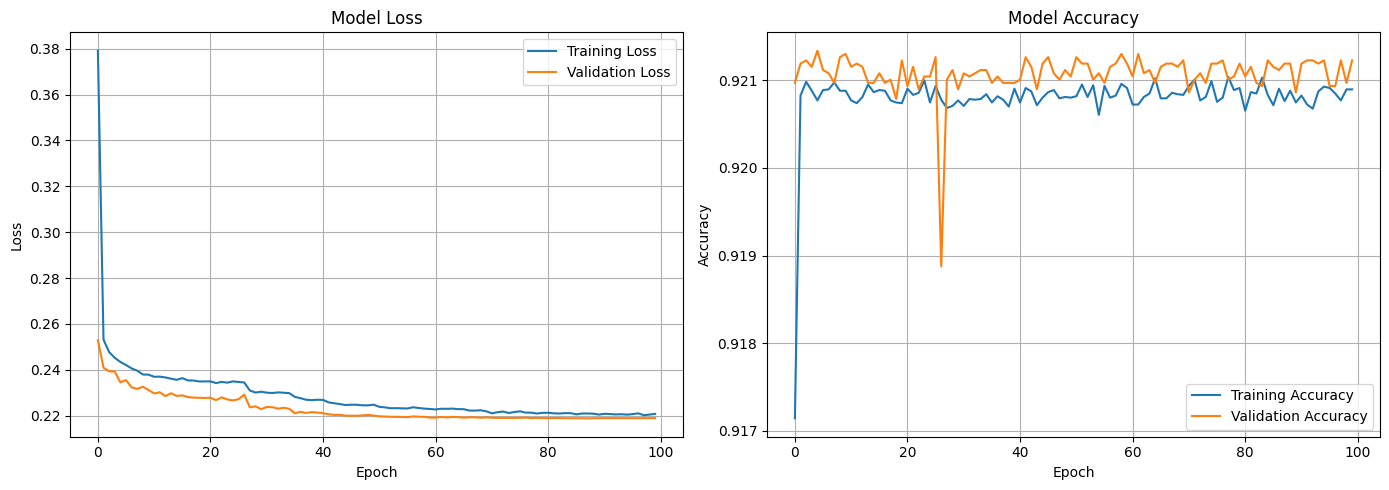

✅ Training history plots generated.

🔢 Plotting Confusion Matrix...


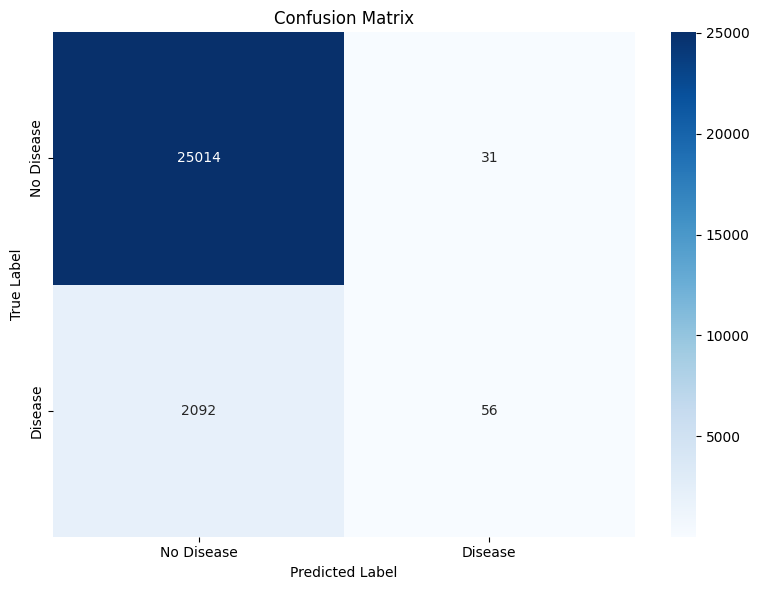

✅ Confusion matrix plot generated.

✅ Visualization complete!


In [15]:
"""
STEP 9: Visualize Training History and Evaluation Results
Plot loss/accuracy curves and the confusion matrix
"""

print("=" * 60)
print("VISUALIZING RESULTS")
print("=" * 60)

# 1. Plot Training History
print("\n📈 Plotting Training History (Loss and Accuracy)...")

if history is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Model Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    print("✅ Training history plots generated.")
else:
    print("⚠️ Training history not found. Please run the training step first.")


# 2. Plot Confusion Matrix
print("\n🔢 Plotting Confusion Matrix...")

# Ensure cm is available from the evaluation step (cell qGdLx2snopdt)
if 'cm' in locals():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'], # Update labels based on your data
                yticklabels=['No Disease', 'Disease']) # Update labels based on your data
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    print("✅ Confusion matrix plot generated.")
else:
     print("⚠️ Confusion matrix (cm) not found. Please run the evaluation step first.")

print("\n✅ Visualization complete!")